# **Practical 1 - Karol Pustelnik 446518**

In [1]:
"""Practical 1

Greatly inspired by Stanford CS224 2019 class.
"""

import sys

import pprint
from turtle import window_width
import sklearn
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import random
import nltk

nltk.download('reuters')
nltk.download('pl196x')
import random
import numpy as np
import scipy as sp
from nltk.corpus import reuters
from nltk.corpus.reader import pl196x
from sklearn.decomposition import PCA, TruncatedSVD

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)


[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package pl196x to /root/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!


In [4]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 71.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import gensim

In [3]:
print(gensim.__version__)

4.1.2


# **a) Implement `distinct words` function**

In [4]:
#################################
# TODO: a)
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the 
            corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the 
            corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    for document in corpus:
        for word in document:
            if word not in corpus_words:
                corpus_words.append(word)
    corpus_words = sorted(corpus_words)
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words


# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]     
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set([
    'Ala', 'END', 'START', 'i', 'kot', 'lubic', 'miec', 'pies'])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# **b) Implement `compute co occurrence matrix` function**

In [5]:
#################################
# TODO: b)
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window.
            Words near edges will have a smaller number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the 
                same as the ordering of the words given by the distinct_words 
                function.
            word2Ind (dict): dictionary that maps word to index 
                (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words, num_words))
    word2Ind = {}
    print(M)
    # ------------------
    # Write your implementation here.
    for i, word1 in enumerate(words):
        word2Ind.update({word1: i})
    for document in corpus:
            for word1 in document:
                for word2 in document:

                    if abs(document.index(word2) - document.index(word1))< window_size+1 and word2 !=word1 :
                        M[word2Ind[word1],word2Ind[word2]] +=1
    return M, word2Ind

In [6]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]     
M_test, word2Ind_test = compute_co_occurrence_matrix(
    test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array([
    [0., 0., 2., 0., 0., 1., 1., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1.],
    [2., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1.],
    [0., 1., 0., 1., 0., 1., 1., 0.],
    [1., 0., 0., 0., 1., 0., 0., 0.],
    [1., 0., 0., 0., 1., 0., 0., 0.],
    [0., 1., 0., 1., 0., 0., 0., 0.]
])

word2Ind_ans = {
    'Ala': 0, 'END': 1, 'START': 2, 'i': 3, 'kot': 4, 'lubic': 5, 'miec': 6,
    'pies': 7}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# **c) Implement `reduce to k dim` function**

In [7]:
#################################
# TODO: c)
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality
        (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following
         SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of corpus words, number 
                of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)):
            matrix of k-dimensioal word embeddings.
            In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    svd = sklearn.decomposition.TruncatedSVD(n_components = k, n_iter = n_iters)
    svd.fit(M)
    M_reduced = svd.transform(M)
    # ------------------

    print("Done.")
    return M_reduced

# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]  
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 8), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 8)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

#################################

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Running Truncated SVD over 8 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# **d) Implement `plot embeddings` function**

--------------------------------------------------------------------------------
Outputted Plot:


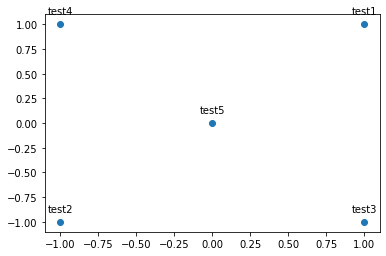

--------------------------------------------------------------------------------


In [8]:
# TODO: d)
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified 
        in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the
            corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to
            visualize
    """

    # ------------------
    xs = []
    ys = []
    for word in words:
        w_index = word2Ind[word]
        vector = M_reduced[w_index,:]
        xs.append(vector[0])
        ys.append(vector[1])
    plt.scatter(xs,ys)
    for i,t in enumerate(zip(xs,ys)):

        label = words[i]

        plt.annotate(label, # this is the text
                 t, # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    plt.show()

    # ------------------#

# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {
    'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

# **e) Co-Occurrence Plot Analysis**

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Running Truncated SVD over 22957 words...
Done.


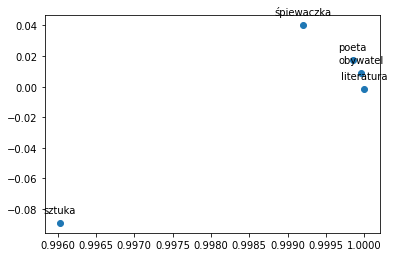

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Running Truncated SVD over 22957 words...
Done.


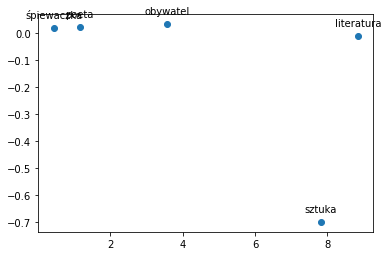

In [9]:
#################################
# TODO: e)
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------

def read_corpus_pl():
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    pl196x_dir = nltk.data.find('corpora/pl196x')
    pl = pl196x.Pl196xCorpusReader(
        pl196x_dir, r'.*\.xml', textids='textids.txt',cat_file="cats.txt")
    tsents = pl.tagged_sents(fileids=pl.fileids(),categories='cats.txt')[:5000]

    return [[START_TOKEN] + [
        w[0].lower() for w in list(sent)] + [END_TOKEN] for sent in tsents]


def plot_unnormalized(corpus, words):
    M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(
        corpus)
    M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
    plot_embeddings(M_reduced_co_occurrence, word2Ind_co_occurrence, words)


def plot_normalized(corpus, words):
    M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(
        corpus)
    M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
    # Rescale (normalize) the rows to make them each of unit-length
    M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
    M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
    plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

pl_corpus = read_corpus_pl()
words = [
    "sztuka", "śpiewaczka", "literatura", "poeta", "obywatel"]

plot_normalized(pl_corpus, words)
plot_unnormalized(pl_corpus, words)


#################################

* What clusters together in 2-dimensional embedding space? 

On normalized plot:

`literatura`, `poeta`, `obywatel`

On not normalized plot:

`śpiewaczka` and `poeta`

* What doesn’t cluster together that you might think should have? 

On normalized plot:

I think all of the words should cluster together. E

On not normalized plot:

I think all of the words should cluster together. Especially `literatura` should cluster with `śpiewczka`, `poeta` and `sztuka`.

* Is normalization necessary?

I think normalization is necessary because if the data set contains an unbalanced number of some words (for example because the data comes from books about nature) then vectors representing these words will have a bigger length. This may result in weird clustering (or lack of clustering) of words.

# **Section 2 Prediction-Based Word Vectors**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **a) Reducing dimensionality of Word2Vec Word Embeddings**

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10005 words...
Done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).


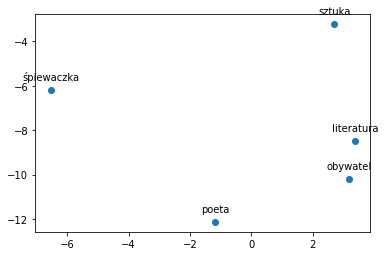

In [12]:
# Section 2:
#################################
# Then run the following to load the word2vec vectors into memory. 
# Note: This might take several minutes.
wv_from_bin_pl = KeyedVectors.load("/content/drive/My Drive/Natural Language processing/Practical_1/word2vec_100_3_polish.bin")

# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------


#################################
# TODO: a)
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors
                         loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------

#################################
# TODO: a)
M, word2Ind = get_matrix_of_vectors(wv_from_bin_pl, words)
M_reduced = reduce_to_k_dim(M, k=2)

words = [
    "sztuka", "śpiewaczka", "literatura", "poeta", "obywatel"]
plot_embeddings(M_reduced, word2Ind, words)



* What clusters together in 2-dimensional embedding space? 

`literatura` and `obywatel`

* What doesn’t cluster together that you might think should have? 

Like I wrote above, I think all words should cluster. Especially `literatura` should cluster with `sztuka` and `poeta`.
* How is the plot different from the one generated earlier from the co-occurrence matrix?


Words are more scattered.

# **b) Polysemous Words**

In [13]:
#################################
# TODO: b)
# Polysemous Words
print(wv_from_bin_pl.most_similar('komentować'))
# Write your polysemous word exploration code here.

print(wv_from_bin_pl.most_similar("stówa"))
# ------------------

#################################

[('relacjonować', 0.8024853467941284), ('przemilczać', 0.7108123898506165), ('opisywać', 0.7035387754440308), ('referować', 0.6902177333831787), ('skomentować', 0.68558669090271), ('parodiować', 0.6824942231178284), ('wykpiwać', 0.6747420430183411), ('krytykować', 0.6696772575378418), ('przytaczać', 0.6656436920166016), ('inscenizować', 0.6649641394615173)]
[('słowa', 0.6893048286437988), ('cent', 0.6367954015731812), ('słowo', 0.6246823072433472), ('stówka', 0.6103435158729553), ('słówko', 0.608944833278656), ('pens', 0.5825462937355042), ('tów', 0.5744858980178833), ('wers', 0.573552668094635), ('centym', 0.5726915597915649), ('komunał', 0.5709105730056763)]


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


# **Answer:**
`'comment'`

`Comment - e.g. a football match`
`Comment - e.g. to criticize`

example:

Dariusz Szpakowski comments on the Poland - Italy match.

Mom commented on her son's unpleasant behavior at the table.

In the sentences above, the word comment has different meanings. In the former, the meaning is literal, in the latter, commenting is understood as criticizing.

# **Why do you think many of the polysemous words you tried didn’t work?**

Many of the words that I tried were not polyesmous because the Polish language is so rich that it is difficult to find words that have completely different meanings depending on the context. The opposite is in English. There are many more of these types of words.

# **c) Synonyms & Antonyms**

In [14]:
#################################
# TODO: c)
# Synonyms & Antonyms
w1 = "ubierać"
w2 = "zakładać"
w3 = "rozbierać"
w1_w2_dist = wv_from_bin_pl.distance(w1, w2)
w1_w3_dist = wv_from_bin_pl.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
# Write your synonym & antonym exploration code here.

w1 = "radosny"
w2 = "pogodny"
w3 = "smutny"
w1_w2_dist = wv_from_bin_pl.distance(w1, w2)
w1_w3_dist = wv_from_bin_pl.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

#################################

Synonyms ubierać, zakładać have cosine distance: 0.7278538644313812
Antonyms ubierać, rozbierać have cosine distance: 0.26450175046920776
Synonyms radosny, pogodny have cosine distance: 0.3306429386138916
Antonyms radosny, smutny have cosine distance: 0.347899854183197


# **Why this counter intuitive result may have happened?**
It seems to me that the word `zakładać` is rarely used in the context of `ubrania`.

# **d) Finding Analogies**

In [15]:
# TODO: d)
# Solving Analogies with Word Vectors
# ------------------
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["kot", "lwica"], negative=["lew"]))
# ------------------
# Write your analogy exploration code here.
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["syn", "kobieta"], negative=["mezczyzna"]))


#################################

[('kocica', 0.7683546543121338),
 ('kotka', 0.7580625414848328),
 ('suczka', 0.7510557770729065),
 ('fretka', 0.7507363557815552),
 ('zwierzątko', 0.7293815016746521),
 ('kociak', 0.7208428978919983),
 ('kocię', 0.7118603587150574),
 ('łasica', 0.7073625326156616),
 ('małpka', 0.7022215127944946),
 ('zwierzak', 0.7007642388343811)]
[('córka', 0.6928777098655701),
 ('dziecko', 0.6763085722923279),
 ('matka', 0.6552439332008362),
 ('żona', 0.6547046899795532),
 ('siostra', 0.6358523368835449),
 ('mąż', 0.6058387160301208),
 ('dziewczę', 0.6008315086364746),
 ('rodzic', 0.5781418681144714),
 ('ojciec', 0.5779308676719666),
 ('rodzeństwo', 0.5768202543258667)]


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


# **Answer**
`lew: kot :: lwica: kocica`

# **e) Incorrect Analogies**

In [16]:
#################################
# TODO: e)
# Incorrect Analogy
# ------------------
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["jeleń", "lwica"], negative=["lew"]))

# ------------------

[('sarenka', 0.733302891254425),
 ('łasica', 0.726658046245575),
 ('kocica', 0.7265701293945312),
 ('gazela', 0.7262505292892456),
 ('tygrysica', 0.715373694896698),
 ('wilczyca', 0.7132043242454529),
 ('antylopa', 0.6952416300773621),
 ('słonica', 0.6938884854316711),
 ('kojot', 0.6847917437553406),
 ('klacz', 0.6847697496414185)]


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


# **Answer**

`lew: jeleń :: lwica: sarenka`

Should `sarna` instead of `sarenka`.

# **f) Guided Analysis of Bias in Word Vectors**

In [17]:
#################################
# TODO: f)
# Guided Analysis of Bias in Word Vectors
# Here `positive` indicates the list of words to be similar to and 
# `negative` indicates the list of words to be most dissimilar from.
# ------------------
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['kobieta', 'szefowa'], negative=['mezczyzna']))
print()
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['mezczyzna', 'szef'], negative=['kobieta']))

[('pracowniczka', 0.643110454082489),
 ('praktykantka', 0.6401199102401733),
 ('dyrektorka', 0.6252585649490356),
 ('prezeska', 0.6222735047340393),
 ('koordynatorka', 0.6162452697753906),
 ('policjantka', 0.6106235980987549),
 ('konsultantka', 0.6103208065032959),
 ('kierowniczka', 0.6071678400039673),
 ('pielęgniarka', 0.6062616109848022),
 ('lekarka', 0.605736494064331)]

[('zastępca', 0.6033658981323242),
 ('pulkownik', 0.5758262276649475),
 ('cielem', 0.5458890199661255),
 ('zastepca', 0.5408223867416382),
 ('usilowaly', 0.5374375581741333),
 ('czlonkiem', 0.5349616408348083),
 ('obowiazków', 0.5332584381103516),
 ('opucil', 0.5332545638084412),
 ('komendant', 0.532918393611908),
 ('obowiazani', 0.5302093029022217)]


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


# **What do you find in the top 10?**

Answer above

# **g) Independent Analysis of Bias in Word Vectors**

In [18]:
#################################
# TODO: g)
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['hindus', 'praca'], negative=['niemiec']))
print()

pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['niemiec', 'praca'], negative=['hindus']))
print()
# ------------------

[('bramin', 0.5531176924705505),
 ('profesja', 0.5462596416473389),
 ('sadhu', 0.5459310412406921),
 ('praktyk', 0.5381325483322144),
 ('medytacja', 0.5359070897102356),
 ('jogini', 0.5339097380638123),
 ('jog', 0.5323072671890259),
 ('zazen', 0.5295499563217163),
 ('swami', 0.5285502672195435),
 ('svatmarama', 0.5278098583221436)]

[('działalność', 0.5820961594581604),
 ('prace', 0.5648640394210815),
 ('akcja', 0.5497881174087524),
 ('naprawa', 0.53857421875),
 ('decyzja', 0.5347055196762085),
 ('robota', 0.523947536945343),
 ('odbudowa', 0.521183967590332),
 ('inwestycja', 0.5211167931556702),
 ('planowanie', 0.5165292024612427),
 ('operacja', 0.5140879154205322)]



/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


# **Briefly explain the example of bias that you discover.**
Bias in terms of different nationalities and attitudes to work.

# **h) The source of bias in word vectors**
The bias manifests itself in the fact that words close to `German` and `work`, as well as distant from `Hindu` are, for example:
`działalność`, `odbudowa`, `naprawa`, `akcja`, `inwestycja`, `planowanie` - and create a German as a proactive worker (plans, repairs, invests, runs a business)

On the other hand, words close to the `Hindu` and `work` and distant to the `German` are:

`Bramin`, `medytacja`, `sadhu`, `zazen` - words used with religion and clergy. So they create a Hindu as a person working mainly on himself (meditates, is a priest, etc.), and less treats work as a way to earn money.

# **i) English versus Polish**

In [20]:
import gensim.downloader as api
wv_from_bin = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [21]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """

    vocab = list(wv_from_bin.key_to_index.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

wv_from_bin = load_word2vec()

Loaded vocab size 3000000


# **b) Polysemous Words**

In [22]:
#################################
# TODO: b)
# Polysemous Words
print(wv_from_bin.most_similar('bank'))
# Write your polysemous word exploration code here.

# ------------------

[('banks', 0.7440759539604187), ('banking', 0.690161406993866), ('Bank', 0.6698698401451111), ('lender', 0.6342284679412842), ('banker', 0.6092953085899353), ('depositors', 0.6031531691551208), ('mortgage_lender', 0.5797975659370422), ('depositor', 0.5716427564620972), ('BofA', 0.5714625120162964), ('Citibank', 0.5589520335197449)]


# **Answer**

`Bank` - diffrent meanings.

bank as a verb (składać pieniądze)

banking as a noun (bankowość)
etc.

# **c) Synonyms & Antonyms**

In [57]:
#################################
# TODO: c)
# Synonyms & Antonyms
w1 = "rich"
w2 = "opulent"
w3 = "poor"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
# Write your synonym & antonym exploration code here.

#################################

Synonyms rich, opulent have cosine distance: 0.6696735620498657
Antonyms rich, poor have cosine distance: 0.627720057964325


# **Why this counter intuitive result may have happened?**
It seems to me that the word `opulent` is rarely used overall so it's distant most of the words.

# **d) Finding Analogies**

In [43]:
# TODO: d)
# Solving Analogies with Word Vectors
# ------------------
pprint.pprint(wv_from_bin.most_similar(
    positive=["man", "waitress"], negative=["waiter"]))
# ------------------


[('woman', 0.773227870464325),
 ('teenage_girl', 0.6492705345153809),
 ('girl', 0.6411365270614624),
 ('teenager', 0.6115584969520569),
 ('boy', 0.5827294588088989),
 ('teen_ager', 0.5439349412918091),
 ('teenaged_girl', 0.5038325190544128),
 ('girlfriend', 0.5008701682090759),
 ('Robbery_suspect', 0.4987116754055023),
 ('Prison_escapee', 0.4952958822250366)]


# **Answer:**

`man: waiter :: woman : waitress`

# **e) Incorrect Analogies**

In [46]:
#################################
# TODO: e)
# Incorrect Analogy
# ------------------
pprint.pprint(wv_from_bin.most_similar(
    positive=["sleep", "kitchen"], negative=["bed"]))

# ------------------


[('kitchens', 0.5266509056091309),
 ('cooking', 0.49796661734580994),
 ('healthful_meals', 0.47584229707717896),
 ('cooks', 0.4682634472846985),
 ('Healthful_eating', 0.46467867493629456),
 ('mealtime', 0.46205735206604004),
 ('bathroom', 0.4584217369556427),
 ('stovetops', 0.4533143937587738),
 ('cook', 0.45076462626457214),
 ('cook_nutritious_meals', 0.43667396903038025)]


# **Answer:**

`Cooking` should be 1st.

# **f) Guided Analysis of Bias in Word Vectors**

In [ ]:
#################################
# TODO: f)
# Guided Analysis of Bias in Word Vectors
# Here `positive` indicates the list of words to be similar to and 
# `negative` indicates the list of words to be most dissimilar from.
# ------------------
pprint.pprint(wv_from_bin.most_similar(
    positive=['woman', 'science'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(
    positive=['man', 'science'], negative=['woman']))

[('biology', 0.5811161994934082),
 ('sciences', 0.5771055221557617),
 ('faith_Jezierski', 0.5717575550079346),
 ('Hilal_Khashan_professor', 0.5432188510894775),
 ('scientific', 0.5337136387825012),
 ('professor_Burdett_Loomis', 0.5317376255989075),
 ('DuPont_http://www.dupont.com', 0.5166647434234619),
 ('arts_humanities', 0.5114614367485046),
 ('Science', 0.5096142888069153),
 ('developmental_psychology', 0.5088647603988647)]

[('faith_Jezierski', 0.5785573720932007),
 ('physics_astronomy', 0.5647080540657043),
 ('sciences', 0.5488621592521667),
 ('mathematics', 0.5483816266059875),
 ('scientific', 0.5455992817878723),
 ('Shlomo_Avineri_professor', 0.5447791814804077),
 ('biology', 0.537142813205719),
 ('physics', 0.5347105264663696),
 ('arithmetic_geometry', 0.5213109850883484),
 ('impeach_USADA', 0.5136756300926208)]


# **Answer**

Sex bias in science (more sciences connected to Math are close to man and far from woman).

# **g) Independent Analysis of Bias in Word Vectors**

In [ ]:
#################################
# TODO: g)
pprint.pprint(wv_from_bin.most_similar(
    positive=['hindu', 'science'], negative=['german']))
print()

pprint.pprint(wv_from_bin.most_similar(
    positive=['german', 'science'], negative=['hindu']))
print()
# ------------------

[('faith_Jezierski', 0.5046392679214478),
 ('biology', 0.4839395582675934),
 ('professor_Kent_Redfield', 0.4803318381309509),
 ('Science', 0.4698144197463989),
 ('impeach_USADA', 0.46569642424583435),
 ('scientific', 0.4614698886871338),
 ('professor_Burdett_Loomis', 0.4595963656902313),
 ('sciences', 0.4588996171951294),
 ('Carl_Shepro_professor', 0.4565400183200836),
 ('Academy_INSA', 0.453952819108963)]

[('sciences', 0.44298893213272095),
 ("magazine_c't", 0.4207650125026703),
 ('bionic_prosthetic_fingers', 0.41890135407447815),
 ('physics_astronomy', 0.4139890670776367),
 ('physics', 0.41334205865859985),
 ('faith_Jezierski', 0.4127029478549957),
 ('Board_BONU_specialty', 0.4116217792034149),
 ('mathematics', 0.4094737768173218),
 ('biology', 0.4091291129589081),
 ('Forschungszentrum_Jülich', 0.4018917381763458)]



# **Answer**

Bias in terms of different nationalities and science.

# **Have you observed any qualitative differences? Answer with up to 7 sentences.**

It is harder to find correct analogies in English because many words don't have a distinction for male or female. However, it is easier to find polysemous words in English because the vocabulary isn't as rich as polish. I mean that many words in English have completly diffrent meaning depending on context. For example Bank (the one I found above) or bear, get etc.